# Testing your app

Once your app is running you can query it. You can simply do that by navigating to the URL that ngrok gave you above or through code in a different python session. For example, once the frontend app is running, you can navigate to:
http://YOUR_SERVER_DOMAIN/search?query=hello+world where YOUR_SERVER_DOMAIN is something like XXXX-XX-XX-XX-XX.ngrok.io, which is printed above in Colab or that is your external IP on GCP.

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [68]:
import json

with open('queries_train.json', 'rt') as f:
  # queries = dict(list(json.load(f).items())[20:])
  queries = json.load(f)

In [34]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [35]:
def avg_time_pres(qs):
  return sum([time for _,time,_ in qs])/len(qs),sum([pres for _,_,pres in qs if pres!= None])/(len(qs))


In [36]:
def prams_to_string(parms):
  return f'title_parms: w_cosine_similarity {parms[0]}, w_boolean {parms[1]},w_BM25_b_k1_k3_baselog {parms[2:7]}     body_parms: w_cosine_similarity {parms[7]}, w_boolean {parms[8]},w_BM25_b_k1_k3_baselog {parms[9:14]}'
  


In [37]:
import requests
from time import time
url = 'http://34.132.244.115:8080'

## **result dict by parameters**

In [38]:
result_dict={}

## **set parameters**

In [71]:
def get_init_param():
  p_title_cosine_similarity = 0
  p_title_boolean = 0.7
  p_title_BM25 = 0.7
  b_title_BM25 = 0.54
  k1_title_BM25 = 1.84
  k3_title_BM25 = 1.95
  base_log_title_BM25 = 10

  p_body_cosine_similarity = 0
  p_body_boolean = 0.3
  p_body_BM25 = 0.3
  b_body_BM25 = 0.54
  k1_body_BM25 = 1.84
  k3_body_BM25 = 1.95
  base_log_body_BM25 = 10

  merge_n=230

  parameters=[p_title_cosine_similarity,p_title_boolean,p_title_BM25,b_title_BM25,k1_title_BM25,k3_title_BM25,base_log_title_BM25,
              p_body_cosine_similarity,p_body_boolean,p_body_BM25,b_body_BM25,k1_body_BM25,k3_body_BM25,base_log_body_BM25,merge_n]
  return parameters



In [55]:
duration, ap = None, None
t_start = time()
qs_res=None
try:
  res = requests.post(url+'/set_parameters',json=get_init_param())
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
qs_res

[True]

## **Auto Tests**


### **Choose model**


In [8]:
import random
def get_parameters_Choose_model():
  parameters=get_init_param()
  parameters[0]=random.randint(0, 2)
  parameters[1]=random.randint(0, 2)
  parameters[2]=random.randint(0, 2)
  parameters[3]=0.75
  parameters[4]=1.75
  parameters[5]=1.75
  parameters[6]=10
  parameters[7]=random.randint(0, 2)
  parameters[8]=random.randint(0, 2)
  parameters[9]=random.randint(0, 2)
  parameters[10]=0.75
  parameters[11]=1.75
  parameters[12]=1.75
  parameters[13]=10

  return parameters

In [9]:
def set_param(parameters):
  duration, ap = None, None
  t_start = time()
  qs_res=None
  try:
    res = requests.post(url+'/set_parameters',json=parameters)
    duration = time() - t_start
    if res.status_code == 200:
      qs_res= res.json()
  except:
    pass
  print(qs_res)

In [10]:
def search():
  qs_res = []
  for q, true_wids in queries.items():
    duration, ap = None, None
    t_start = time()
    try:
      res = requests.get(url + '/search', {'query': q}, timeout=35)
      duration = time() - t_start
      if res.status_code == 200:
        pred_wids, _ = zip(*res.json())
        ap = average_precision(true_wids, pred_wids)
    except:
      pass
    
    qs_res.append((q, duration, ap))
  return(qs_res)

In [ ]:
for a in range(2):
  for b in range(2):
    for c in range(2):
        for d in range(2):
            for e in range(2):
                if (a+b+c+d+e==0):
                  continue
                parameters = get_parameters_Choose_model()
                parameters[0]=0
                parameters[1]=b
                parameters[2]=c
                parameters[7]=d
                parameters[8]=e
                parameters[9]=a   
                set_param(parameters)
                qs_res = search()
                result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)




In [ ]:
result_dict


### **Find weights**

In [11]:
import random
def get_parameters_Find_weights():
  parameters=get_init_param()
  parameters[0]=0
  parameters[1]=round(random.uniform(0, 1),3)
  parameters[2]=0
  parameters[3]=0.75
  parameters[4]=1.75
  parameters[5]=1.75
  parameters[6]=10
  parameters[7]=0
  parameters[8]=round(1-parameters[1])
  parameters[9]=0
  parameters[10]=0.75
  parameters[11]=1.75
  parameters[12]=1.75
  parameters[13]=10

  return parameters

In [ ]:
for i in range(30):
  parameters = get_parameters_Find_weights()
  set_param(parameters)
  qs_res = search()
  print(qs_res)
  print(parameters)
  result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)

### **Word2Vec**

In [64]:
result_dict={}

In [27]:
without_w2v=avg_time_pres(search())

In [34]:
with_w2v=avg_time_pres(search())

In [38]:
result_dict["without"]=without_w2v
result_dict["with_w2v"]=with_w2v


## **find query facrtor** 

In [46]:
parameters=get_init_param()
parameters.append(0)
for i in range(1,10):
  parameters[15]=i
  set_param(parameters)
  qs_res = search()
  result_dict[prams_to_string(parameters)+str(i)] = avg_time_pres(qs_res)

[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]


In [43]:
result_dict

{'title_parms: w_cosine_similarity 0, w_boolean 0.7,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]     body_parms: w_cosine_similarity 0, w_boolean 0.3,w_BM25_b_k1_k3_baselog [0, 0, 0, 0, 0]': (1.408300805091858,
  0.0)}

## **BM25 vs Cosine_Similarity**

In [72]:
parameters=get_init_param()
set_param(parameters)
qs_res = search()
result_dict["BM25"] = avg_time_pres(qs_res)

[True]


In [85]:
parameters=get_init_param()
set_param(parameters)
qs_res = search()
result_dict[i] = avg_time_pres(qs_res)

[True]


### **find N**

In [52]:
for i in range(100,250,10):
  parameters=get_init_param()
  parameters[14]=i
  set_param(parameters)
  qs_res = search()
  result_dict[i] = avg_time_pres(qs_res)

[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]
[True]


### **Stemming vs NONStemming**

In [57]:
parameters=get_init_param()
set_param(parameters)
qs_res = search()
result_dict["Stemming"] = avg_time_pres(qs_res)

[True]


In [60]:
parameters=get_init_param()
set_param(parameters)
qs_res = search()
result_dict["NonStemming"] = avg_time_pres(qs_res)

[True]


### **final result**

In [65]:
parameters=get_init_param()
set_param(parameters)
qs_res = search()
result_dict["Last10"] = avg_time_pres(qs_res)

[True]


In [72]:
parameters=get_init_param()
set_param(parameters)
qs_res = search()
result_dict["All30"] = avg_time_pres(qs_res)

[True]


## **Plot Test Results** 

<ipython-input-73-0335a1aa388b>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(range(len(labels)),["BM25","Cosine_Similarity"])


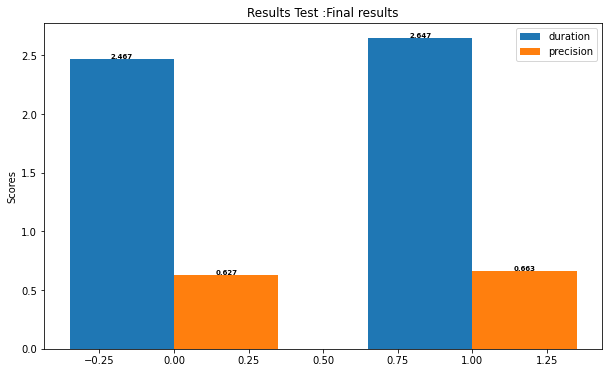

(2.6472996711730956, 0.6634666666666666)
All30


<Figure size 432x288 with 0 Axes>

In [73]:
from nltk.metrics.scores import precision
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np


labels = result_dict.keys()
duration,precision = zip(*result_dict.values())


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, duration, width, label='duration')
rects2 = ax.bar(x + width/2, precision, width, label='precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Results Test :Final results')
ax.set_xticks(range(len(labels)),["BM25","Cosine_Similarity"])
ax.legend()

for bar in rects1:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2, height, round(height,3), ha='center', va='bottom',fontsize=7,fontweight='bold')

for bar in rects2:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2, height, round(height,3), ha='center', va='bottom',fontsize=7,fontweight='bold')
# fig.tight_layout()
fig.set_size_inches(10,6)
plt.show()
plt.savefig("choosing_test.jpg") #save as png
max_key = max(result_dict, key = lambda x: result_dict.get(x)[1])


print(result_dict[max_key])
print(max_key)

## **Test search**

In [48]:

# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below. 


qs_res = []
for q, true_wids in queries.items():
  duration, ap,rc = None, None,None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))
  


In [49]:
qs_res

[('best marvel movie', 4.920014142990112, 0.867),
 ('How do kids come to world?', 7.877712249755859, 0.0),
 ('Information retrieval', 0.8833026885986328, 1.0),
 ('LinkedIn', 0.02552056312561035, 1.0),
 ('How to make coffee?', 2.1878459453582764, 0.0),
 ('Ritalin', 0.008104801177978516, 0.771),
 ('How to make wine at home?', 5.747897386550903, 0.0),
 ('Most expensive city in the world', 9.915420293807983, 0.5),
 ('India', 2.1855695247650146, 0.661),
 ('how to make money fast?', 3.533029317855835, 1.0),
 ('Netflix', 0.12916350364685059, 1.0),
 ('Apple computer', 1.3058652877807617, 0.68),
 ('The Simpsons', 0.06329822540283203, 0.766),
 ('World cup', 7.171169757843018, 0.622),
 ('How to lose weight?', 1.149634599685669, 1.0),
 ('Java', 0.18502497673034668, 0.887),
 ('Air Jordan', 2.452096939086914, 1.0),
 ('how to deal with depression?', 1.0281143188476562, 1.0),
 ('How do you make gold', 4.15368390083313, 0.583),
 ('Marijuana', 0.07253551483154297, 0.295)]

In [50]:
avg_time_pres(qs_res)

(2.7497501969337463, 0.6816)

In [ ]:
result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)

In [ ]:
result_dict 

## **Test search_body**

In [ ]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_body', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

In [ ]:
avg_time_pres(qs_res)

## **Test search_title**

In [ ]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_title', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

In [ ]:
avg_time_pres(qs_res)

## **Test search_anchor**

In [ ]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_anchor', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

In [ ]:
avg_time_pres(qs_res)

## **Test Page Rank**

In [ ]:
qs_res = []
lst = [100,200,300,565677,54656,89897]

duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/get_pagerank',json=lst)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

## **Test Page View**

In [ ]:
qs_res = []
lst = [100,200,300,565677,54656,89897]

duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/get_pageview',json=lst)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res